# KNN -  K Nearest Neighbors - Classification

To understand KNN for classification, we'll work with a simple dataset representing gene expression levels. Gene expression levels are calculated by the ratio between the expression of the target gene (i.e., the gene of interest) and the expression of one or more reference genes (often household genes). This dataset is synthetic and specifically designed to show some of the strengths and limitations of using KNN for Classification.


More info on gene expression: https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Data

In [2]:
df = pd.read_csv('../DATA/gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [5]:
df.describe()

,Gene One,Gene Two,Cancer Present
count,3000.000000,3000.000000,3000.000000
mean,5.600133,5.410467,0.500000
std,1.828388,1.729081,0.500083
min,1.000000,1.000000,0.000000
25%,4.300000,4.000000,0.000000
50%,5.600000,5.400000,0.500000
75%,6.900000,6.700000,1.000000
max,10.000000,10.000000,1.000000


In [59]:
df['Cancer Present'].value_counts()

0    1500
1    1500
Name: Cancer Present, dtype: int64

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

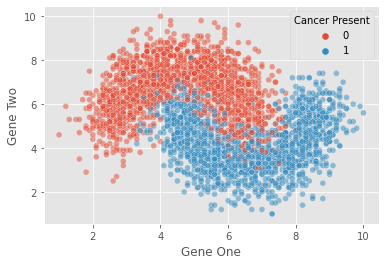

In [6]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df,alpha=0.5)

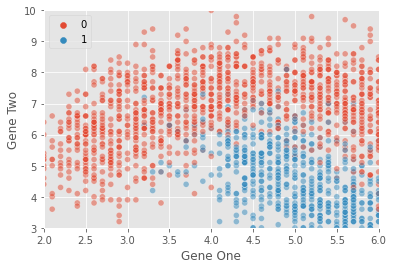

In [7]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df,alpha=0.5)
plt.xlim(2,6)
plt.ylim(3,10)
plt.legend(loc=0)

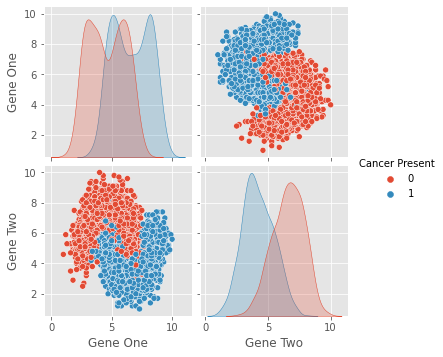

In [8]:
sns.pairplot(df,hue='Cancer Present')

## Train|Test Split and Scaling Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
scaler = StandardScaler()

In [13]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [15]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [16]:
log_model = LogisticRegression()
log_model.fit(scaled_X_train,y_train)

LogisticRegression()

In [17]:
pred = log_model.predict(scaled_X_test)

In [18]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

# Understanding KNN and Choosing K Value

In [19]:
full_test = pd.concat([X_test,y_test],axis=1)

In [20]:
len(full_test)

900

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

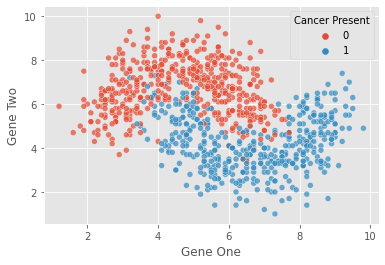

In [21]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',
                data=full_test,alpha=0.7)

## Model Evaluation

In [22]:
y_pred = knn_model.predict(scaled_X_test)

In [23]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix

In [24]:
accuracy_score(y_test,y_pred)

0.8922222222222222

In [25]:
accuracy_score(y_test, pred)

0.8566666666666667

In [26]:
confusion_matrix(y_test,y_pred)

array([[420,  50],
       [ 47, 383]], dtype=int64)

In [27]:
confusion_matrix(y_test, pred)

array([[400,  70],
       [ 59, 371]], dtype=int64)

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



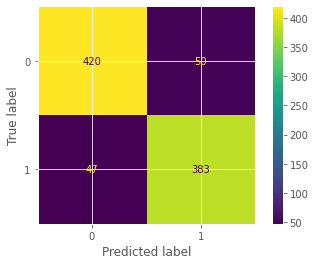

In [29]:
plot_confusion_matrix(knn_model, scaled_X_test,y_test)

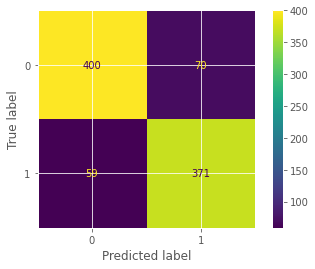

In [30]:
plot_confusion_matrix(log_model, scaled_X_test,y_test)

## Elbow Method for Choosing Reasonable K Values

**NOTE: This uses the test set for the hyperparameter selection of K.**

In [31]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

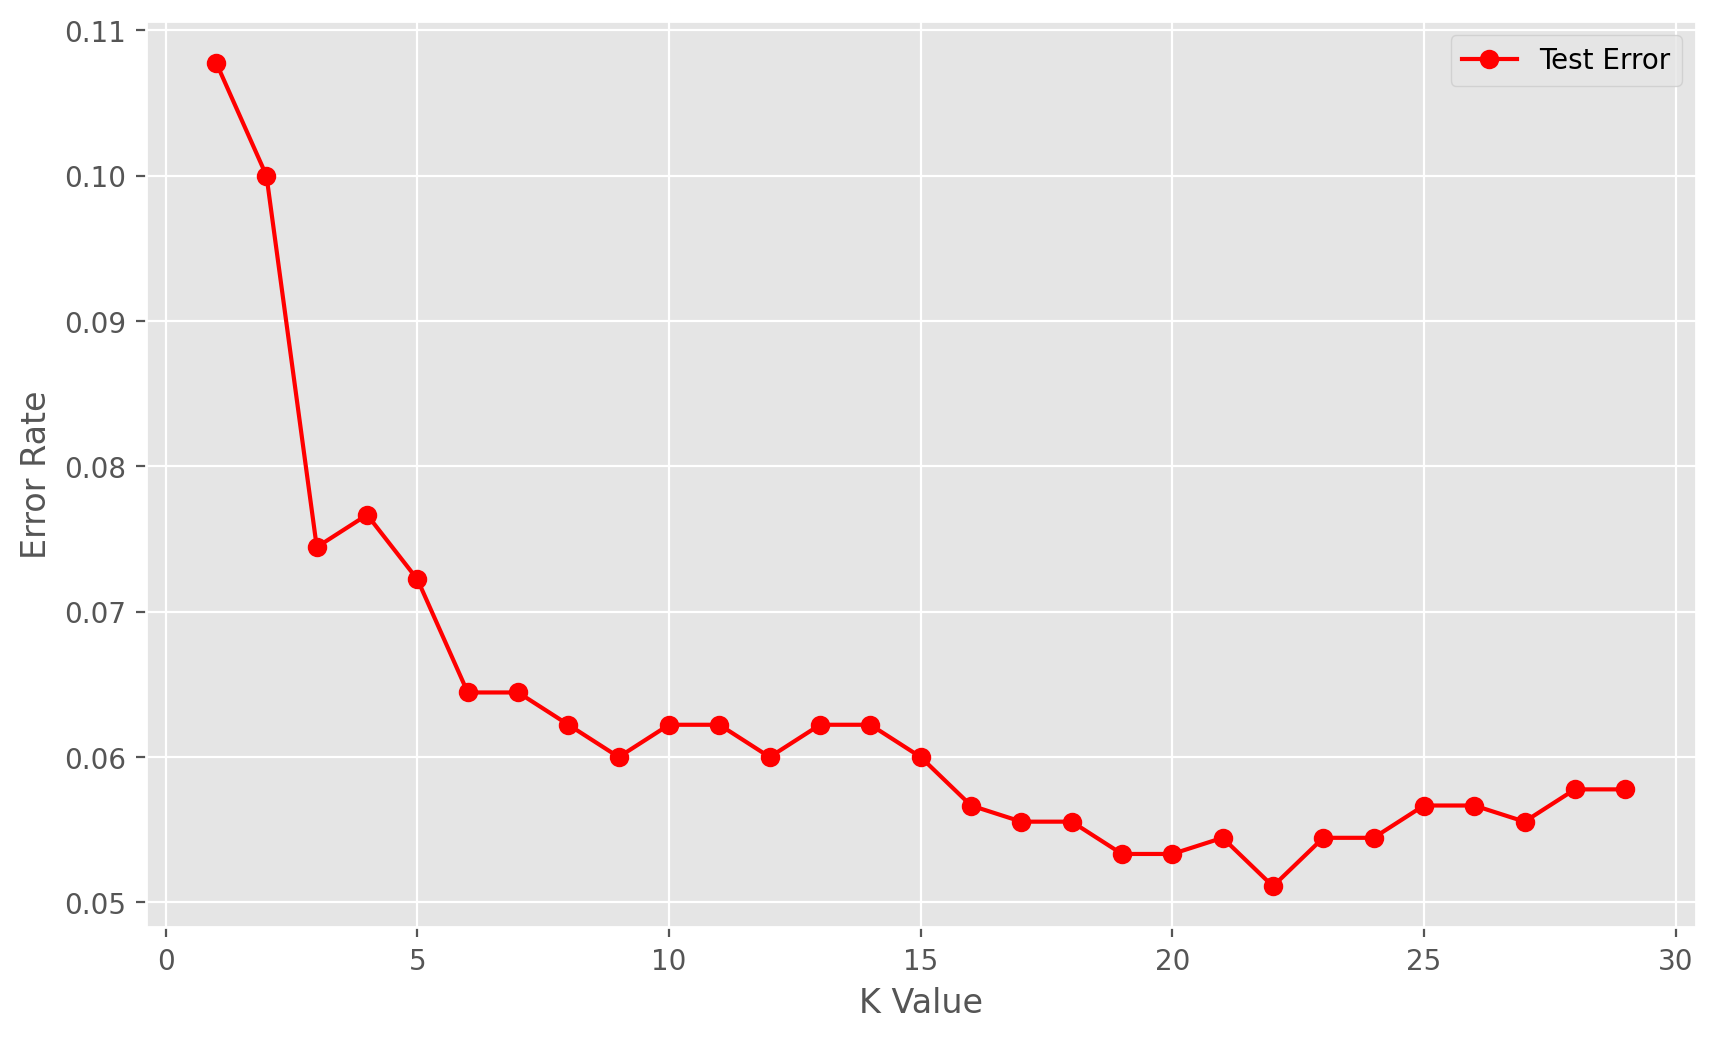

In [32]:
plt.figure(figsize=(10,6),dpi=200)
plt.plot(range(1,30),test_error_rates,label='Test Error',marker='o',color='r')
plt.legend(loc=0)
plt.ylabel('Error Rate')
plt.xlabel("K Value")
plt.show()

## Full Cross Validation Grid Search for K Value

### Creating a Pipeline to find K value

**Follow along very carefully here! We use very specific string codes AND variable names here so that everything matches up correctly. This is not a case where you can easily swap out variable names for whatever you want!**

We'll use a Pipeline object to set up a workflow of operations:

1. Scale Data
2. Create Model on Scaled Data

----
*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! [Full Info in Documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
* Step 1: the scaler is fitted on the TRAINING data
* Step 2: the scaler transforms TRAINING data
* Step 3: the models are fitted/trained using the transformed TRAINING data
* Step 4: the scaler is used to transform the TEST data
* Step 5: the trained models predict using the transformed TEST data

----

In [33]:
scaler = StandardScaler()

In [34]:
knn = KNeighborsClassifier()

In [35]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [36]:
# Highly recommend string code matches variable name!
operations = [('scaler',scaler),('knn',knn)]

In [37]:
from sklearn.pipeline import Pipeline

In [38]:
pipe = Pipeline(operations)

In [39]:
from sklearn.model_selection import GridSearchCV

---
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

---

In [40]:
k_values = list(range(1,20))

In [41]:
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [42]:

param_grid = {'knn__n_neighbors': k_values}

In [43]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='f1')

In [44]:
# Use full X and y if you DON'T want a hold-out test set
# Use X_train and y_train if you DO want a holdout test set (X_test,y_test)
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='f1')

In [45]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=17))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=17),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 17,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [46]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Let's check our understanding:
**How many total runs did we do?**

In [47]:
len(k_values)

19

In [48]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.9038687 , 0.89942318, 0.91956577, 0.91222915, 0.9252441 ,
       0.92164022, 0.92671845, 0.92519532, 0.92663793, 0.92278171,
       0.92670011, 0.92580865, 0.92912921, 0.93011947, 0.9296956 ,
       0.92906511, 0.93040417, 0.92947216, 0.92907142])

In [49]:
len(full_cv_classifier.cv_results_['mean_test_score'])

19

## Final Model

We just saw that our  GridSearch recommends a K=14 (in line with our alternative Elbow Method). Let's now use the PipeLine again, but this time, no need to do a grid search, instead we will evaluate on our hold-out Test Set.

In [62]:
scaler = StandardScaler()
knn17 = KNeighborsClassifier(n_neighbors=17)
operations = [('scaler',scaler),('knn17',knn17)]

In [63]:
pipe = Pipeline(operations)

In [64]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn17', KNeighborsClassifier(n_neighbors=17))])

In [65]:
pipe_pred = pipe.predict(X_test)

In [66]:
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       470
           1       0.95      0.94      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [55]:
single_sample = X_test.iloc[40]

In [56]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [57]:
pipe.predict(single_sample.values.reshape(1, -1))

array([0], dtype=int64)

In [58]:
pipe.predict_proba(single_sample.values.reshape(1, -1))

array([[0.92857143, 0.07142857]])

----